In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random

# APPL

In [2]:
data = pd.read_csv('/kaggle/input/apple-daily-dataset/AAPL_day_new_data.csv')
data.tail()

,Date,Open,High,Low,Close,Volume,SMA,EMA,RSI,MACD,MACD_Signal,BB_Upper,BB_Lower
3792,2025-01-30,238.407871,240.525538,236.949483,237.329056,55658300,239.744405,236.706177,51.292711,-2.704714,-3.445377,251.151412,218.947722
3793,2025-01-31,246.918527,246.918527,233.183628,235.740814,101075100,239.964164,236.668320,49.385834,-2.320950,-3.220492,248.879821,219.778898
3794,2025-02-03,229.737419,231.575395,225.452122,227.759583,73063300,239.963964,236.318957,41.114113,-2.630510,-3.102495,247.705859,219.370598
3795,2025-02-04,227.000419,232.873966,226.401072,232.544327,45067300,240.054265,236.170933,46.860376,-2.461376,-2.974271,246.484818,219.536799
3796,2025-02-05,228.279016,232.414468,228.019307,232.214691,39620300,240.123589,236.015786,46.523548,-2.327110,-2.844839,244.739628,220.030366


In [3]:
def preprocessing(data):
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    
    data.fillna(method='ffill', inplace=True)
    data.fillna(method='bfill', inplace=True)
    
    data['Volume'] = pd.to_numeric(data['Volume'], errors='coerce')

    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
    scaler = MinMaxScaler()

    data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

    return data

In [4]:
apple_stock = preprocessing(data)
columns = ['Open', 'Low', 'High', 'Volume', 'SMA', 'EMA', 'RSI', 'MACD', 'MACD_Signal', 'BB_Upper', 'BB_Lower' ]

<ipython-input-3-80cb02926627>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
<ipython-input-3-80cb02926627>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


In [5]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.batch_norm = nn.BatchNorm1d(hidden_size)
  
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers, 
                          dropout=dropout if num_layers > 1 else 0, 
                          batch_first=True, bidirectional=False)
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        batch_size = x.size(0)
        device = x.device
        
        h1 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        
        out, h1 = self.rnn(x, h1)
       
        out = out.transpose(1, 2)  
        out = self.batch_norm(out)
        out = out.transpose(1, 2)  
        
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        
        return out

In [6]:
def create_sequences(data, targets, sequence_length):
    sequences = []
    labels = []
    
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]  
        label = targets[i + sequence_length] 
        sequences.append(seq)
        labels.append(label)

    sequences = np.array(sequences)
    labels = np.array(labels)

    # sequences = np.transpose(sequences, (0, 2, 1))  
    return sequences, labels

In [7]:
def prepare_dataloaders(data, feature_columns, target_column, sequence_length, batch_size, test_size=0.1):
    X = data[feature_columns].values
    y = data[target_column].values
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=test_size, shuffle=False)
    
    x_train, y_train = create_sequences(X_train, Y_train, sequence_length)
    x_val, y_val = create_sequences(X_val, Y_val, sequence_length)
    x_test, y_test = create_sequences(X_test, Y_test, sequence_length)
    
    train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
    test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, val_dataloader, test_dataloader, y_test

In [8]:
def evaluate_model(model, dataloader, criterion, device='cuda'):
    model.eval()
    total_loss = 0.0
    all_targets = []
    all_outputs = []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).view(-1)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            all_targets.append(targets.cpu().detach().numpy())
            all_outputs.append(outputs.cpu().detach().numpy())
            
    avg_loss = total_loss / len(dataloader.dataset)
    targets = np.concatenate(all_targets)
    outputs = np.concatenate(all_outputs)
    
    mse = np.mean((outputs - targets) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(outputs - targets))
    
    return avg_loss, rmse, mae

In [9]:
def evaluate_on_test(model, test_dataloader, criterion, device):
    model.eval()  
    test_loss = 0.0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():  
        for inputs, targets in test_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).squeeze()
            
            if outputs.dim() == 0:
                outputs = outputs.unsqueeze(0)
            if targets.dim() == 0:
                targets = targets.unsqueeze(0)

            loss = criterion(outputs, targets)  
            test_loss += loss.item() * inputs.size(0) 
            
            pred_np = outputs.cpu().numpy()
            target_np = targets.cpu().numpy()
            
            if np.ndim(pred_np) == 0:
                pred_np = np.array([pred_np])
            if np.ndim(target_np) == 0:
                target_np = np.array([target_np])
            
            all_predictions.append(outputs.cpu().numpy())  
            all_targets.append(targets.cpu().numpy())
    
    test_loss /= len(test_dataloader.dataset)
    
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    
    rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
    mae = mean_absolute_error(all_targets, all_predictions)
    
    return all_predictions, all_targets

In [10]:
def plot_metrics(predictions, targets, name):
    
    predictions_natural = predictions.flatten()
    targets_natural = targets.flatten() 

    plt.figure(figsize=(10, 6))
    plt.plot(targets_natural, label="Real Values", color='blue')
    plt.plot(predictions_natural, label="Predicted Values", color='red', linestyle='dashed')
    
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title('Real vs Predicted Values')
    plt.legend()
    if name != '':
        plt.savefig(name, dpi=99) 
    plt.show()

In [11]:
def train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, name_model=""):
    model.to(device)
    best_val_loss = float('inf')
    
    train_rmse_list, train_mae_list = [], []
    val_rmse_list, val_mae_list = [], []
    train_loss_list, val_loss_list = [], []

    for epoch in range(num_epochs):
        model.train()
        all_train_targets = []
        all_train_outputs = []
        batch_inputs, batch_targets = [], []

        for inputs, targets in train_dataloader:
            batch_inputs.append(inputs.to(device))
            batch_targets.append(targets.float().to(device))
        
        inputs = torch.cat(batch_inputs)
        targets = torch.cat(batch_targets)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        outputs = outputs.view_as(targets)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss = loss.item() * inputs.size(0)
        all_train_targets.append(targets.cpu().detach().numpy())
        all_train_outputs.append(outputs.cpu().detach().numpy())

        train_targets = np.concatenate(all_train_targets)
        train_outputs = np.concatenate(all_train_outputs)

        train_mse = np.mean((train_outputs - train_targets) ** 2)
        train_rmse = np.sqrt(train_mse)
        train_mae = np.mean(np.abs(train_outputs - train_targets))

        train_rmse_list.append(train_rmse)
        train_mae_list.append(train_mae)
        train_loss_list.append(train_loss / len(train_dataloader.dataset))

        val_loss, val_rmse, val_mae = evaluate_model(model, val_dataloader, criterion, device)
        val_rmse_list.append(val_rmse)
        val_mae_list.append(val_mae)
        val_loss_list.append(val_loss)

        if val_loss < best_val_loss and name_model != '':
            best_val_loss = val_loss
            torch.save(model.state_dict(), name_model)

        if ((epoch + 1) % 100) == 0:
            print(f'Epoch {epoch+1}/{num_epochs}:')
            print(f'Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}')
            print(f'Val RMSE: {val_rmse:.4f}, Val MAE: {val_mae:.4f}')

    if name_model != '':
        torch.save(model.state_dict(), name_model)

    return train_loss_list, val_loss_list

In [12]:
def evaluate_and_plot(test_dataloader, model, criterion, device, png, train_loss_list, val_loss_list, num_epochs):
    model.to(device)

    test_loss, test_rmse, test_mae = evaluate_model(model, test_dataloader, criterion, device)
    predictions, targets = evaluate_on_test(model, test_dataloader, criterion, device)

    print('\nFinal Results:')
    print(f'Test RMSE: {test_rmse:.4f}')
    print(f'Test MAE: {test_mae:.4f}')

    plot_metrics(predictions, targets, png)

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_loss_list, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_loss_list, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


In [13]:
def seed_everything(seed_value=0):
    random.seed(seed_value)  
    np.random.seed(seed_value)  
    torch.manual_seed(seed_value) 
    torch.cuda.manual_seed(seed_value) 
    torch.cuda.manual_seed_all(seed_value) 
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False

## LR 

In [14]:
seed_everything(0)
num_epochs = 50
input_size = 11
hid_size = 100
num_layers = 1
dropout = 0.3

model = RNN(input_size, hid_size, num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

In [15]:
seed_everything(0)
num_epochs = 50
input_size = 11
hid_size = 100
num_layers = 1
dropout = 0.3

model = RNN(input_size, hid_size, num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

In [16]:
seed_everything(0)
num_epochs = 50
input_size = 11
hid_size = 100
num_layers = 1
dropout = 0.3

model = RNN(input_size, hid_size, num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.000001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

## DROPOUT

In [17]:
seed_everything(0)
num_epochs = 50
input_size = 11
hid_size = 100
num_layers = 1
dropout = 0.2

model = RNN(input_size, hid_size, num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

In [18]:
seed_everything(0)
num_epochs = 50
input_size = 11
hid_size = 100
num_layers = 1
dropout = 0.1

model = RNN(input_size, hid_size, num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

In [19]:
seed_everything(0)
num_epochs = 50
input_size = 11
hid_size = 100
num_layers = 1
dropout = 0.4

model = RNN(input_size, hid_size, num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

## NUM LAYERS

In [20]:
seed_everything(0)
num_epochs = 50
input_size = 11
hid_size = 100
num_layers = 2
dropout = 0.3

model = RNN(input_size, hid_size, num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

In [21]:
seed_everything(0)
num_epochs = 50
input_size = 11
hid_size = 100
num_layers = 3
dropout = 0.3

model = RNN(input_size, hid_size, num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

## HIDDEN SIZE

In [22]:
seed_everything(0)
num_epochs = 50
input_size = 11
hid_size = 256
num_layers = 1
dropout = 0.3

model = RNN(input_size, hid_size, num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

In [23]:
seed_everything(0)
num_epochs = 50
input_size = 11
hid_size = 50
num_layers = 1
dropout = 0.3

model = RNN(input_size, hid_size, num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

## NUM EPOCH

In [24]:
seed_everything(0)
num_epochs = 100
input_size = 11
hid_size = 100
num_layers = 1
dropout = 0.3

model = RNN(input_size, hid_size, num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/100:
Train RMSE: 0.2736, Train MAE: 0.2004
Val RMSE: 0.1093, Val MAE: 0.0895


In [25]:
seed_everything(0)
num_epochs = 200
input_size = 11
hid_size = 100
num_layers = 1
dropout = 0.3

model = RNN(input_size, hid_size, num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/200:
Train RMSE: 0.2736, Train MAE: 0.2004
Val RMSE: 0.1093, Val MAE: 0.0895
Epoch 200/200:
Train RMSE: 0.1961, Train MAE: 0.1440
Val RMSE: 0.0561, Val MAE: 0.0440


## Test timestep 5

Epoch 100/200:
Train RMSE: 0.2390, Train MAE: 0.1790
Val RMSE: 0.1149, Val MAE: 0.0911
Epoch 200/200:
Train RMSE: 0.1905, Train MAE: 0.1407
Val RMSE: 0.0679, Val MAE: 0.0534

Final Results:
Test RMSE: 0.0670
Test MAE: 0.0527


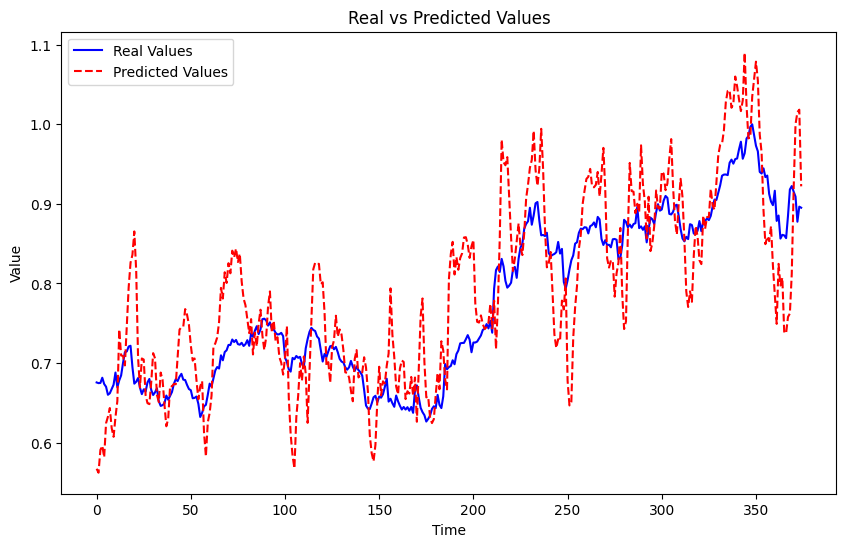

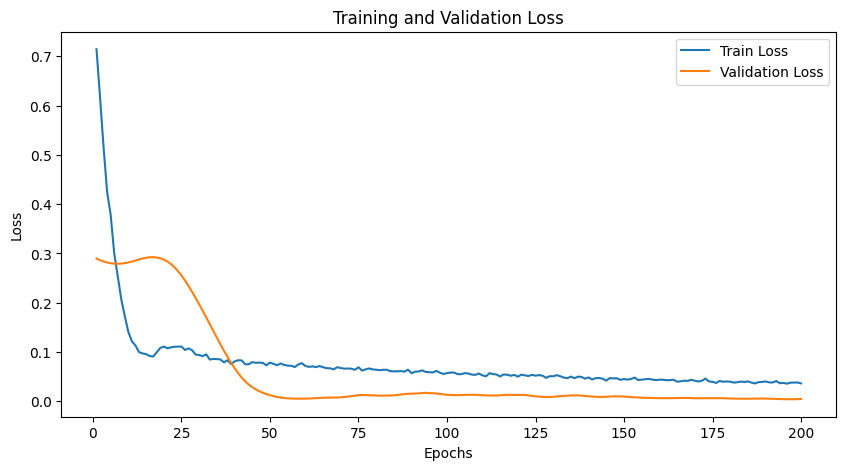

In [26]:
seed_everything(0)
num_epochs = 200
input_size = 11
hid_size = 100
num_layers = 1
dropout = 0.2

model = RNN(input_size, hid_size, num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', 5, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'rnn_model_apple_5.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'apple_step_5_rnn.png', train_losses, val_losses, num_epochs)

## Test timestep 10

Epoch 100/200:
Train RMSE: 0.2233, Train MAE: 0.1664
Val RMSE: 0.1021, Val MAE: 0.0820
Epoch 200/200:
Train RMSE: 0.1865, Train MAE: 0.1359
Val RMSE: 0.0556, Val MAE: 0.0434

Final Results:
Test RMSE: 0.0571
Test MAE: 0.0465


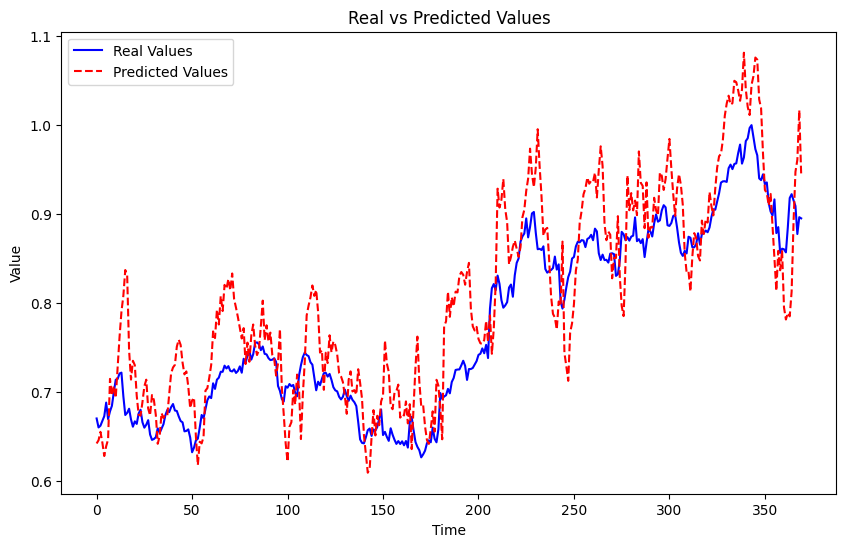

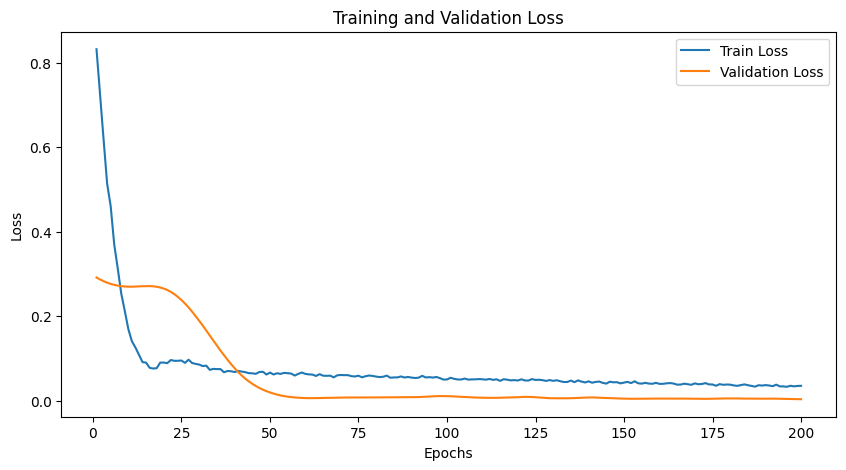

In [27]:
seed_everything(0)
num_epochs = 200
input_size = 11
hid_size = 100
num_layers = 1
dropout = 0.2

model = RNN(input_size, hid_size, num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'rnn_model_apple_10.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'apple_step_10_rnn.png', train_losses, val_losses, num_epochs)

## Test timestep 20

Epoch 100/200:
Train RMSE: 0.2272, Train MAE: 0.1651
Val RMSE: 0.0757, Val MAE: 0.0594
Epoch 200/200:
Train RMSE: 0.1937, Train MAE: 0.1442
Val RMSE: 0.0403, Val MAE: 0.0307

Final Results:
Test RMSE: 0.0432
Test MAE: 0.0353


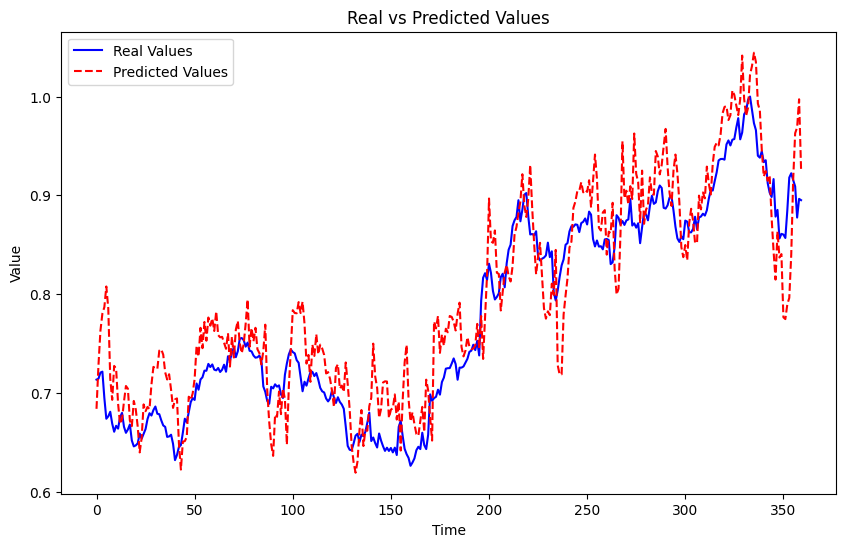

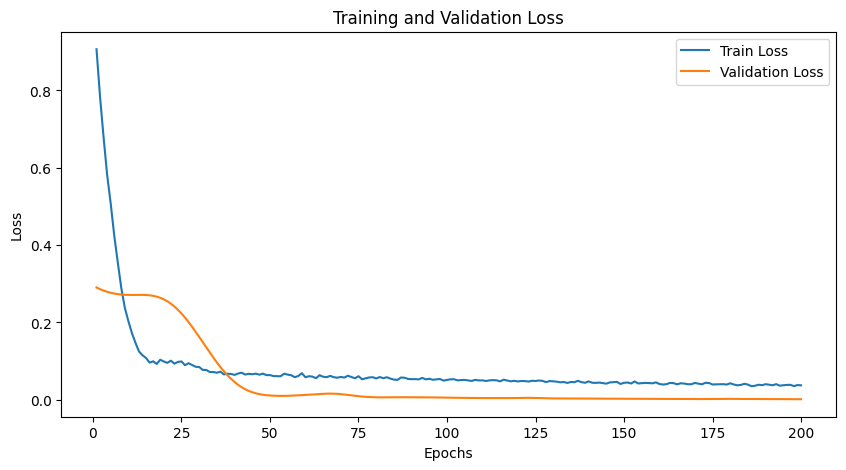

In [28]:
seed_everything(0)
num_epochs = 200
input_size = 11
hid_size = 100
num_layers = 1
dropout = 0.2

model = RNN(input_size, hid_size, num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(apple_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'rnn_model_apple_20.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'apple_step_20_rnn.png', train_losses, val_losses, num_epochs)

# META

In [29]:
data = pd.read_csv('/kaggle/input/meta-dataset/META_day.csv')
meta_stock = preprocessing(data)

<ipython-input-3-80cb02926627>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
<ipython-input-3-80cb02926627>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


## Learning rate

In [30]:
seed_everything(0)
num_epochs = 50
input_size = 11
hid_size = 100
num_layers = 1
dropout = 0.3

model = RNN(input_size, hid_size, num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

In [31]:
seed_everything(0)
num_epochs = 50
input_size = 11
hid_size = 100
num_layers = 1
dropout = 0.3

model = RNN(input_size, hid_size, num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

In [32]:
seed_everything(0)
num_epochs = 50
input_size = 11
hid_size = 100
num_layers = 1
dropout = 0.3

model = RNN(input_size, hid_size, num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

## Dropout

In [33]:
seed_everything(0)
num_epochs = 50
input_size = 11
hid_size = 100
num_layers = 1
dropout = 0.2

model = RNN(input_size, hid_size, num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

In [34]:
seed_everything(0)
num_epochs = 50
input_size = 11
hid_size = 100
num_layers = 1
dropout = 0.4

model = RNN(input_size, hid_size, num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

In [35]:
seed_everything(0)
num_epochs = 50
input_size = 11
hid_size = 100
num_layers = 1
dropout = 0.1

model = RNN(input_size, hid_size, num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

## Number epoches

In [36]:
seed_everything(0)
num_epochs = 100
input_size = 11
hid_size = 100
num_layers = 1
dropout = 0.3

model = RNN(input_size, hid_size, num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/100:
Train RMSE: 0.2366, Train MAE: 0.1800
Val RMSE: 0.0863, Val MAE: 0.0723


In [37]:
seed_everything(0)
num_epochs = 200
input_size = 11
hid_size = 100
num_layers = 1
dropout = 0.3

model = RNN(input_size, hid_size, num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/200:
Train RMSE: 0.2366, Train MAE: 0.1800
Val RMSE: 0.0863, Val MAE: 0.0723
Epoch 200/200:
Train RMSE: 0.1606, Train MAE: 0.1192
Val RMSE: 0.0518, Val MAE: 0.0413


In [38]:
seed_everything(0)
num_epochs = 250
input_size = 11
hid_size = 100
num_layers = 1
dropout = 0.3

model = RNN(input_size, hid_size, num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device)

Epoch 100/250:
Train RMSE: 0.2366, Train MAE: 0.1800
Val RMSE: 0.0863, Val MAE: 0.0723
Epoch 200/250:
Train RMSE: 0.1606, Train MAE: 0.1192
Val RMSE: 0.0518, Val MAE: 0.0413


## Timestep = 5

Epoch 100/200:
Train RMSE: 0.2143, Train MAE: 0.1636
Val RMSE: 0.0790, Val MAE: 0.0633
Epoch 200/200:
Train RMSE: 0.1580, Train MAE: 0.1195
Val RMSE: 0.0355, Val MAE: 0.0262

Final Results:
Test RMSE: 0.0807
Test MAE: 0.0631


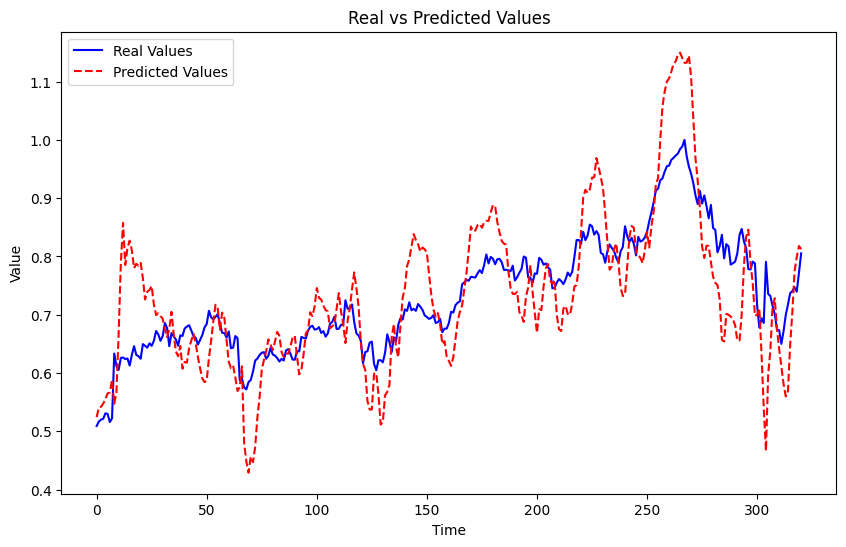

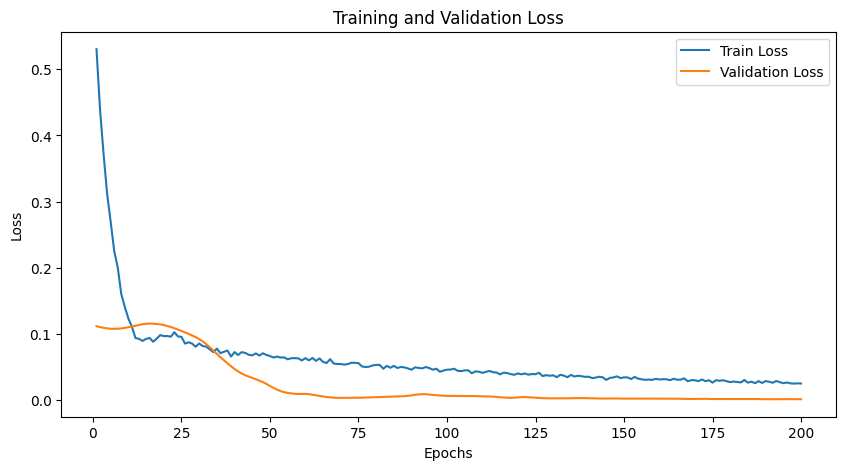

In [39]:
seed_everything(0)
num_epochs = 200
input_size = 11
hid_size = 100
num_layers = 1
dropout = 0.2

model = RNN(input_size, hid_size, num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', 5, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'rnn_model_meta_5.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'meta_step_5_rnn.png', train_losses, val_losses, num_epochs)

## Timestep = 10

Epoch 100/200:
Train RMSE: 0.2024, Train MAE: 0.1551
Val RMSE: 0.0838, Val MAE: 0.0705
Epoch 200/200:
Train RMSE: 0.1516, Train MAE: 0.1143
Val RMSE: 0.0579, Val MAE: 0.0490

Final Results:
Test RMSE: 0.0861
Test MAE: 0.0672


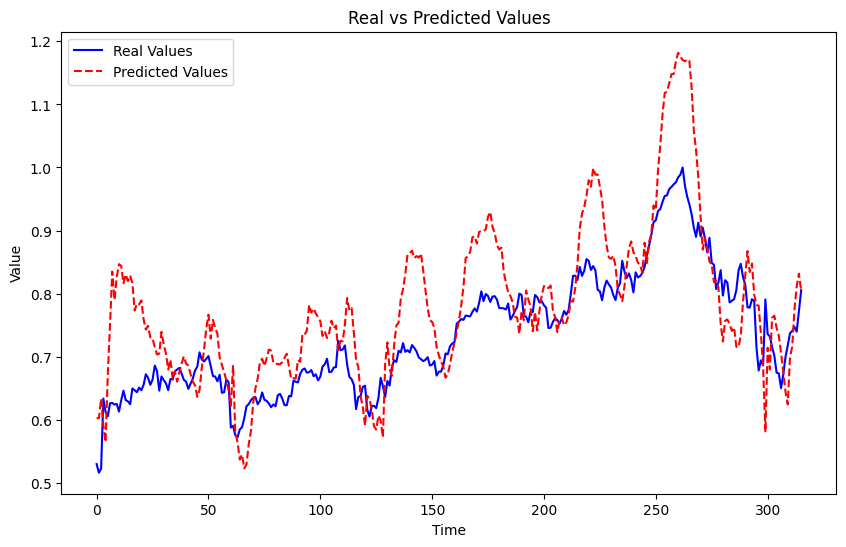

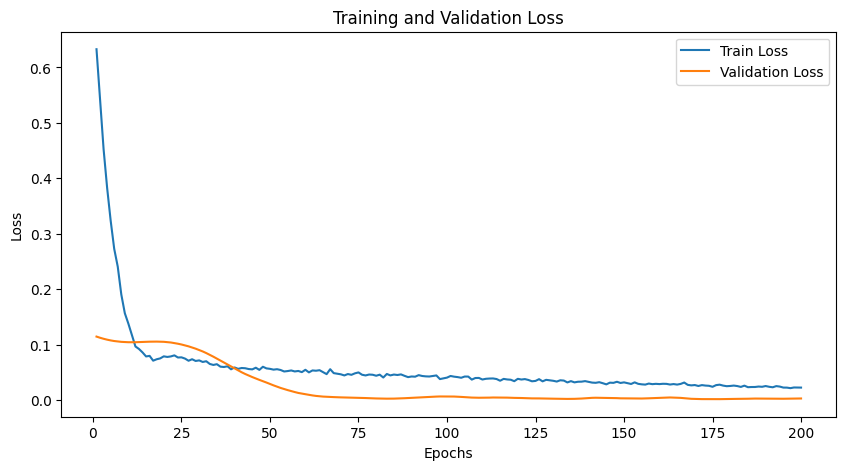

In [40]:
seed_everything(0)
num_epochs = 200
input_size = 11
hid_size = 100
num_layers = 1
dropout = 0.2

model = RNN(input_size, hid_size, num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'rnn_model_meta_10.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'meta_step_10_rnn.png', train_losses, val_losses, num_epochs)

## Timestep = 20

Epoch 100/200:
Train RMSE: 0.2003, Train MAE: 0.1514
Val RMSE: 0.0586, Val MAE: 0.0464
Epoch 200/200:
Train RMSE: 0.1709, Train MAE: 0.1299
Val RMSE: 0.0387, Val MAE: 0.0338

Final Results:
Test RMSE: 0.0468
Test MAE: 0.0391


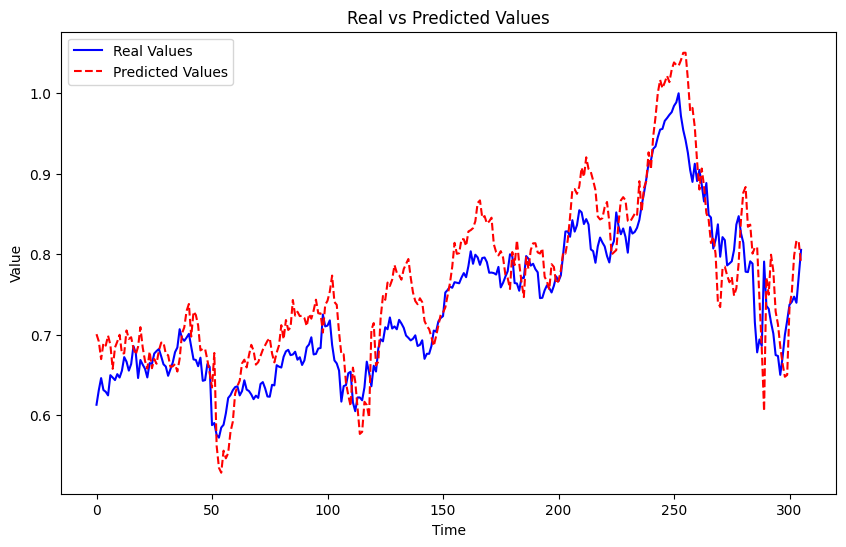

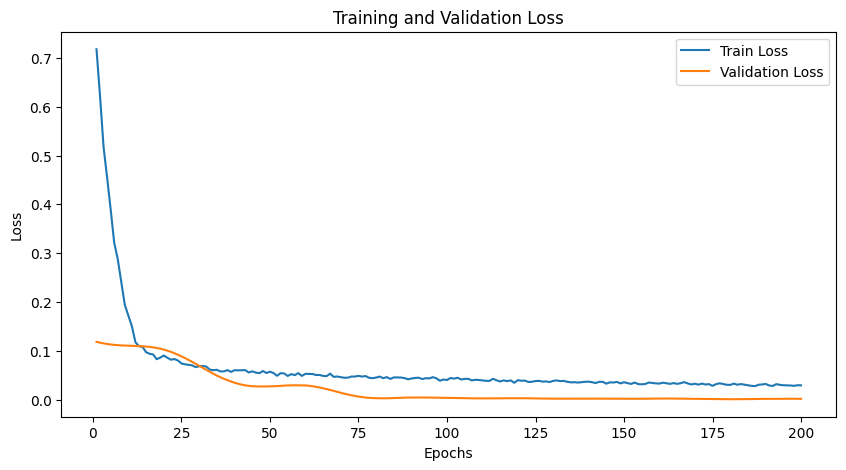

In [41]:
seed_everything(0)
num_epochs = 200
input_size = 11
hid_size = 100
num_layers = 1
dropout = 0.2

model = RNN(input_size, hid_size, num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(meta_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'rnn_model_meta_20.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'meta_step_20_rnn.png', train_losses, val_losses, num_epochs)

# TESLA

In [42]:
columns = ['Open', 'Low', 'High', 'Volume', 'SMA', 'EMA', 'RSI', 'MACD', 'MACD_Signal', 'BB_Upper', 'BB_Lower']
data = pd.read_csv('/kaggle/input/tesla-dataset/Tesla_day.csv')
tesla_stock = preprocessing(data)

<ipython-input-3-80cb02926627>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
<ipython-input-3-80cb02926627>:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


## timeStep = 5

Epoch 100/200:
Train RMSE: 0.2269, Train MAE: 0.1628
Val RMSE: 0.1039, Val MAE: 0.0848
Epoch 200/200:
Train RMSE: 0.1809, Train MAE: 0.1235
Val RMSE: 0.0498, Val MAE: 0.0408

Final Results:
Test RMSE: 0.0610
Test MAE: 0.0470


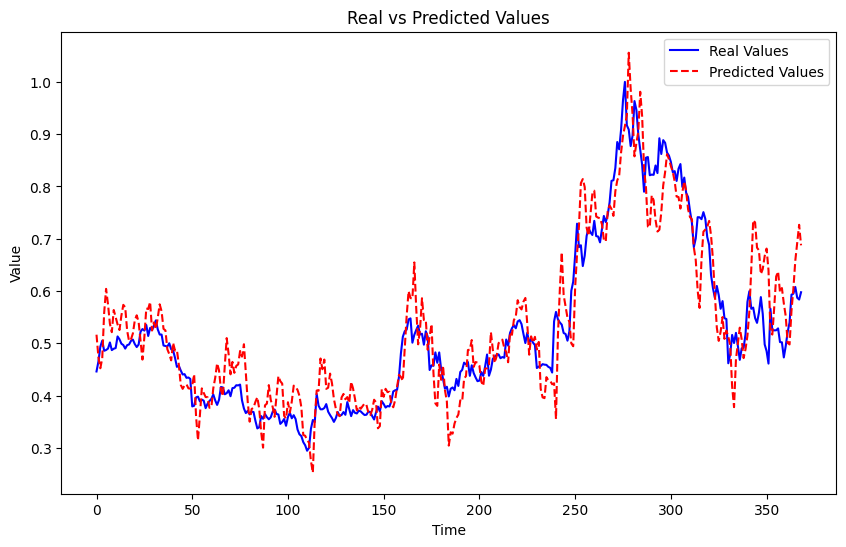

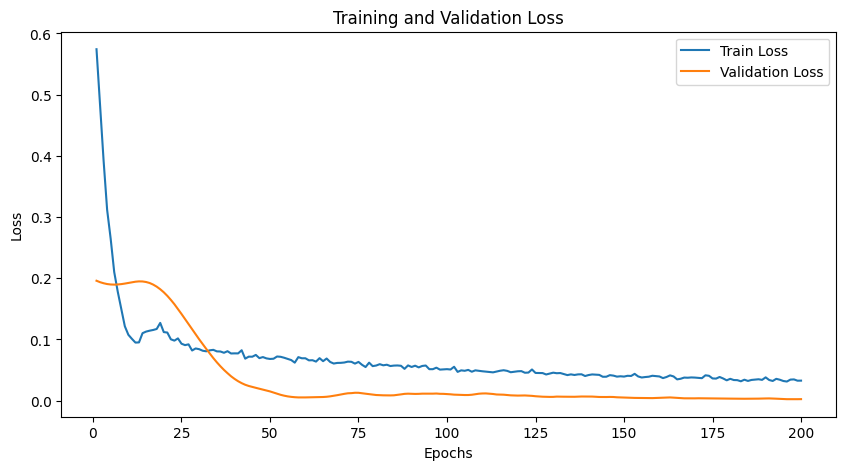

In [43]:
seed_everything(0)
num_epochs = 200
input_size = 11
hid_size = 100
num_layers = 1
dropout = 0.2

model = RNN(input_size, hid_size, num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', 5, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'model_tesla_rnn_5.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'tesla_rnn_step_5.png', train_losses, val_losses, num_epochs)

## timeStep = 10

Epoch 100/200:
Train RMSE: 0.2197, Train MAE: 0.1554
Val RMSE: 0.0843, Val MAE: 0.0689
Epoch 200/200:
Train RMSE: 0.1814, Train MAE: 0.1253
Val RMSE: 0.0407, Val MAE: 0.0328

Final Results:
Test RMSE: 0.0537
Test MAE: 0.0412


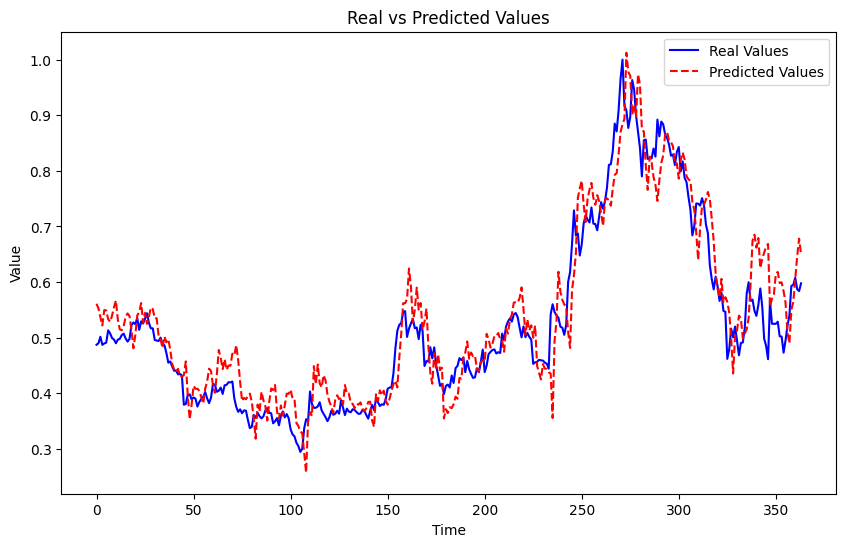

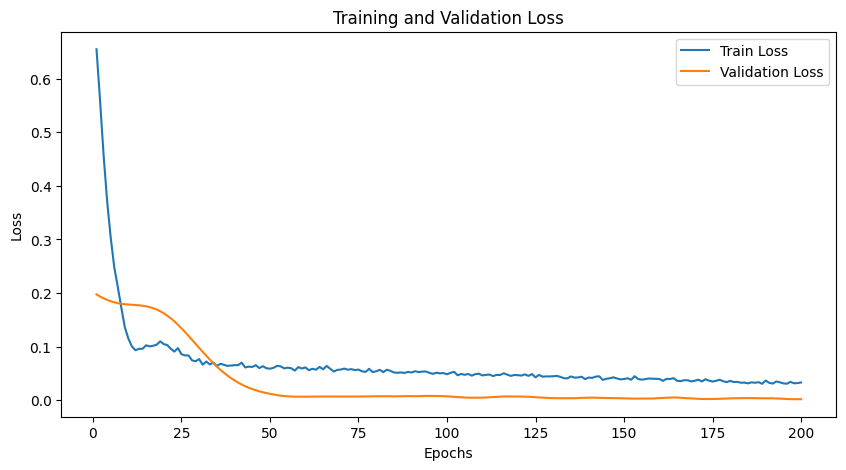

In [44]:
seed_everything(0)
num_epochs = 200
input_size = 11
hid_size = 100
num_layers = 1
dropout = 0.2

model = RNN(input_size, hid_size, num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', 10, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'fractal_model_rnn_10.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'tesla_step_10_rnn.png', train_losses, val_losses, num_epochs)

## timeStep = 20

Epoch 100/200:
Train RMSE: 0.2223, Train MAE: 0.1539
Val RMSE: 0.0810, Val MAE: 0.0668
Epoch 200/200:
Train RMSE: 0.1904, Train MAE: 0.1368
Val RMSE: 0.0340, Val MAE: 0.0267

Final Results:
Test RMSE: 0.0479
Test MAE: 0.0362


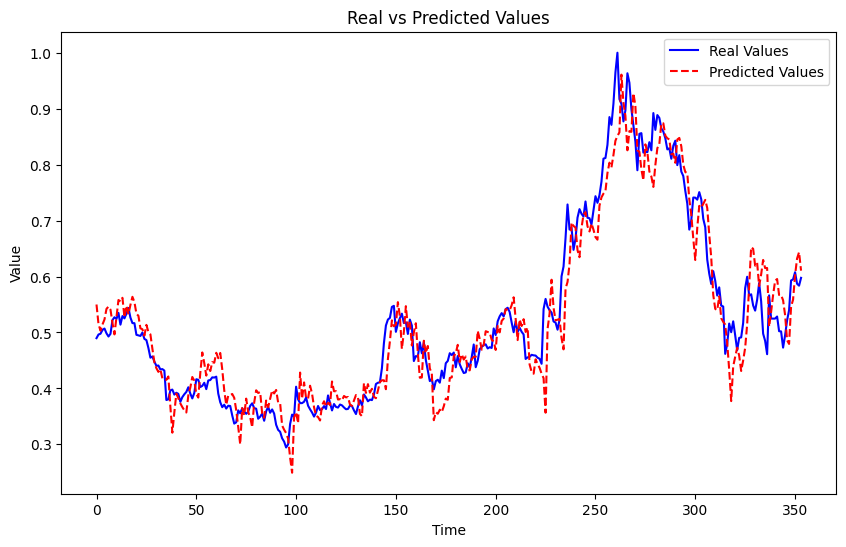

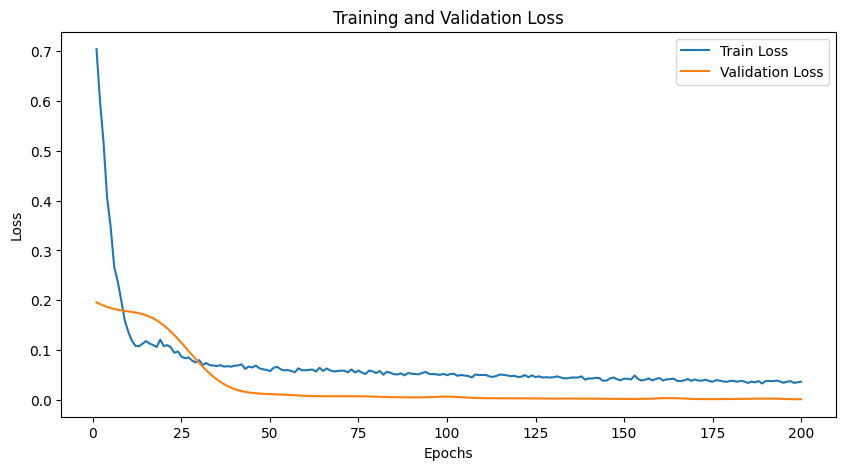

In [45]:
seed_everything(0)
num_epochs = 200
input_size = 11
hid_size = 100
num_layers = 1
dropout = 0.2

model = RNN(input_size, hid_size, num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataloader, val_dataloader, test_dataloader, targets = prepare_dataloaders(tesla_stock, columns, 'Close', 20, 64)
train_losses, val_losses = train_model(train_dataloader, val_dataloader, model, criterion, optimizer, num_epochs, device, 'rnn_model_tesla_20.pth')
evaluate_and_plot(test_dataloader, model, criterion, device, 'tesla_step_20_rnn.png', train_losses, val_losses, num_epochs)